<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#DCGAN-with-Batch-Normalization" data-toc-modified-id="DCGAN-with-Batch-Normalization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>DCGAN with Batch Normalization</a></span></li><li><span><a href="#Getting-Started--With-imports" data-toc-modified-id="Getting-Started--With-imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Getting Started  With imports</a></span></li><li><span><a href="#Generator" data-toc-modified-id="Generator-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generator</a></span></li><li><span><a href="#Discriminator" data-toc-modified-id="Discriminator-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Discriminator</a></span></li><li><span><a href="#Noise-Generation" data-toc-modified-id="Noise-Generation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Noise Generation</a></span></li><li><span><a href="#loss-Function" data-toc-modified-id="loss-Function-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>loss Function</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Training</a></span></li></ul></div>

# DCGAN with Batch Normalization

[PyTorch documentation](https://pytorch.org/docs/stable/index.html) 

# Getting Started  With imports



In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.cuda.empty_cache()
torch.manual_seed(0) 

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_tensor = image_tensor.detach().cpu()
    image_grid = make_grid(image_tensor[:num_images], nrow=5)
    return plt.imshow(image_grid.permute(1, 2, 0).squeeze())

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

**Data used : MNIST Dataset**
The training images your discriminator will be using is from a dataset called [MNIST](http://yann.lecun.com/exdb/mnist/). It contains 60,000 images of handwritten digits, from 0 to 9.

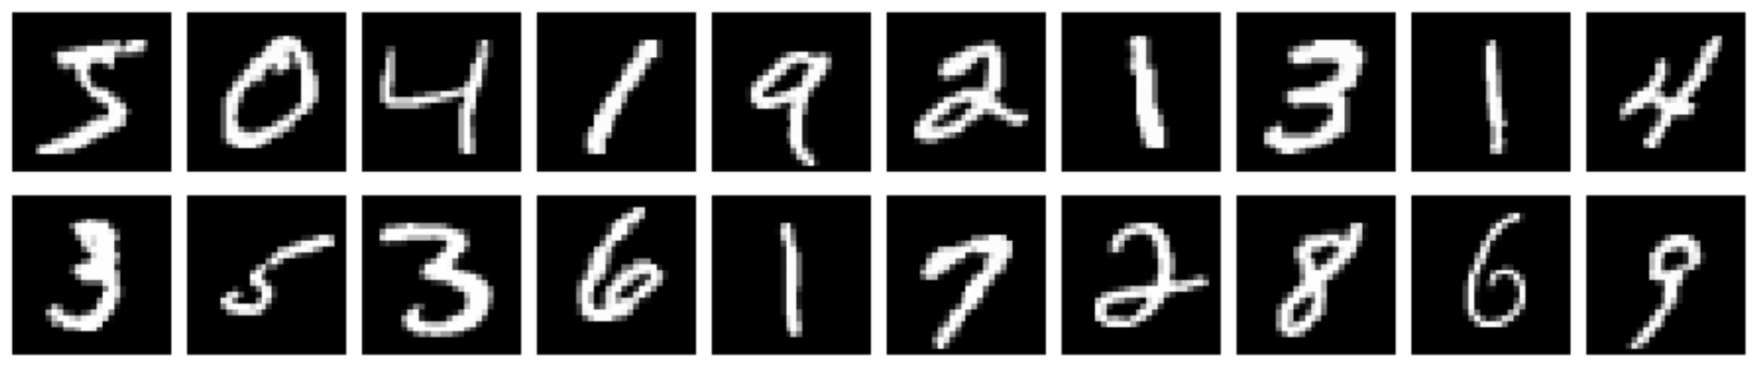

# Generator 

**Generator  Blocks**
the block consist of one DEConv , followed by Batch Normalization then one relu activation

**Generator Module**
consist of 3 blocks

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=128):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.block(z_dim, hidden_dim * 4, kernel_size= 3,stride =2),
            self.block(hidden_dim * 4, hidden_dim * 2, kernel_size= 4,stride =1),
            self.block(hidden_dim * 2, hidden_dim , kernel_size= 3,stride =2),
            nn.ConvTranspose2d(hidden_dim, im_chan, kernel_size= 4,stride =2),
            nn.Tanh()
        )
    def block(self, input_channels, output_channels, kernel_size=3, stride=2):
        return nn.Sequential(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
        nn.BatchNorm2d(output_channels),
        nn.ReLU(inplace=True)
                        )
    
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise.view(len(noise), self.z_dim, 1, 1))
    

# Discriminator

**Discriminator  Blocks**
the block consist of one conv layer and one Leaky-relu activation.

**Discriminator Module**
consist of 2 blocks means 2 Hidden layers each layer followed by Leaky-relu activation the output linear layer.

In [3]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.block(im_chan, hidden_dim, kernel_size= 4,stride =2 ),
            self.block(hidden_dim, hidden_dim * 2, kernel_size= 4,stride =2 ),
            nn.Conv2d( hidden_dim * 2, 1, kernel_size= 4,stride =2)
        )
        
    def block(self, input_channels, output_channels, kernel_size=4, stride=2):
        return nn.Sequential(
        nn.Conv2d(input_channels, output_channels, kernel_size, stride),
        #nn.Dropout2d(p=0.1, inplace=True),
        nn.BatchNorm2d(output_channels),
        nn.LeakyReLU(0.2, inplace=True)
                        )
    
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

# Noise Generation

In [4]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples,z_dim,device=device)


# loss Function

In [5]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

In [6]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

# Training

*   criterion: the loss function
*   n_epochs: the number of times you iterate through the entire dataset when training
*   z_dim: the dimension of the noise vector
*   display_epoch: how often to display/visualize the images
*   batch_size: the number of images per forward/backward pass
*   lr: the learning rate
*   device: using a GPU (CUDA)

In [7]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 50
z_dim = 64
display_epoch = 5
batch_size = 128

lr = 0.0002
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Load MNIST dataset as tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
dataloader = DataLoader( MNIST('.', download=False, transform=transform),
                            batch_size=batch_size,
                            shuffle=True)
steps_per_ep =len(dataloader)

gen = Generator(z_dim).to(device)
disc = Discriminator().to(device) 

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(.5, 0.999))

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0



In [8]:

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 ,Step:468 ,Generator loss: 0.8031011993315683 ,discriminator loss: 0.6034659074821955


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2 ,Step:937 ,Generator loss: 1.5548531139837405 ,discriminator loss: 0.3496584782341139


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3 ,Step:1406 ,Generator loss: 1.1069401227144273 ,discriminator loss: 0.5547702362034114


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4 ,Step:1875 ,Generator loss: 0.9273373971361591 ,discriminator loss: 0.6054431926975381


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5 ,Step:2344 ,Generator loss: 0.8661069505250267 ,discriminator loss: 0.6265954412122787


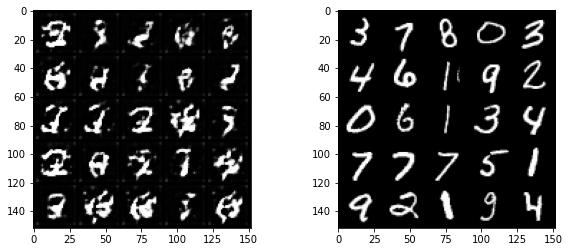

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6 ,Step:2813 ,Generator loss: 0.8188632189083708 ,discriminator loss: 0.6353431007246984


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7 ,Step:3282 ,Generator loss: 0.8059291662946183 ,discriminator loss: 0.6530785203488396


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8 ,Step:3751 ,Generator loss: 0.7987444619380075 ,discriminator loss: 0.664232160618056


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9 ,Step:4220 ,Generator loss: 0.7699919105338643 ,discriminator loss: 0.6687806126659617


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10 ,Step:4689 ,Generator loss: 0.7611168545446428 ,discriminator loss: 0.673370119223971


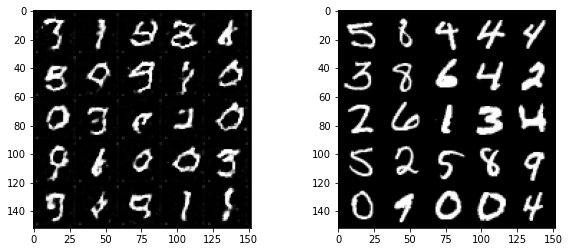

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11 ,Step:5158 ,Generator loss: 0.7532952366861448 ,discriminator loss: 0.6783612717443437


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12 ,Step:5627 ,Generator loss: 0.7490408909854605 ,discriminator loss: 0.6808767785141469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13 ,Step:6096 ,Generator loss: 0.737447336093703 ,discriminator loss: 0.6846348375145563


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14 ,Step:6565 ,Generator loss: 0.7299076874118885 ,discriminator loss: 0.6872680009301027


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15 ,Step:7034 ,Generator loss: 0.7279129348584067 ,discriminator loss: 0.6895391934716116


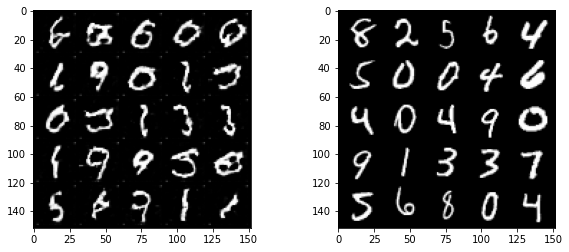

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16 ,Step:7503 ,Generator loss: 0.7237026582140403 ,discriminator loss: 0.6915265804668987


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17 ,Step:7972 ,Generator loss: 0.7218424879920002 ,discriminator loss: 0.6935573413427953


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18 ,Step:8441 ,Generator loss: 0.7142857058978528 ,discriminator loss: 0.6947834035480961


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19 ,Step:8910 ,Generator loss: 0.7137317032193827 ,discriminator loss: 0.695504164899082


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 20 ,Step:9379 ,Generator loss: 0.7110859473376901 ,discriminator loss: 0.6964730655969084


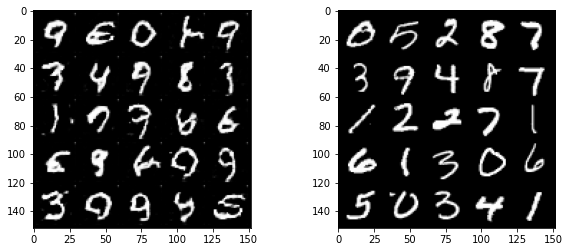

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 21 ,Step:9848 ,Generator loss: 0.7078271871690807 ,discriminator loss: 0.6960059728449597


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 22 ,Step:10317 ,Generator loss: 0.7036531261924992 ,discriminator loss: 0.6969152092933657


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 23 ,Step:10786 ,Generator loss: 0.7026109458413957 ,discriminator loss: 0.6972890136592675


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 24 ,Step:11255 ,Generator loss: 0.7000874268856133 ,discriminator loss: 0.6980869011329938


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 25 ,Step:11724 ,Generator loss: 0.6958407062584401 ,discriminator loss: 0.6995268528903725


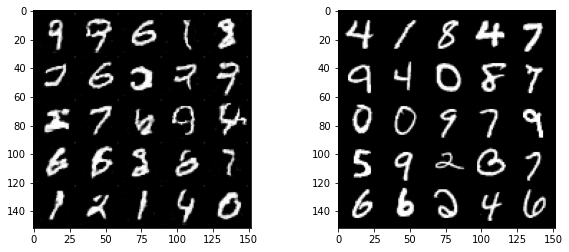

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 26 ,Step:12193 ,Generator loss: 0.6969728454597969 ,discriminator loss: 0.6987914303218381


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 27 ,Step:12662 ,Generator loss: 0.6956915897347016 ,discriminator loss: 0.6983827104700653


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 28 ,Step:13131 ,Generator loss: 0.6971383326089201 ,discriminator loss: 0.6977809478224978


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 29 ,Step:13600 ,Generator loss: 0.6953192911168398 ,discriminator loss: 0.6972457408142502


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 30 ,Step:14069 ,Generator loss: 0.6972029196428087 ,discriminator loss: 0.6976321955987892


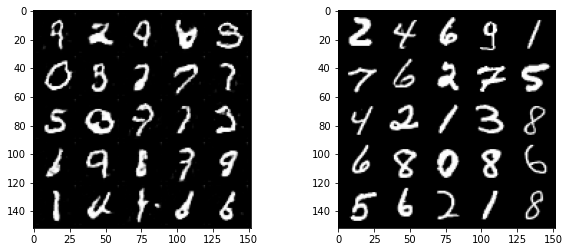

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 31 ,Step:14538 ,Generator loss: 0.6945515141558289 ,discriminator loss: 0.6967048591642239


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 32 ,Step:15007 ,Generator loss: 0.6956366343793078 ,discriminator loss: 0.6966262112802535


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 33 ,Step:15476 ,Generator loss: 0.6952462958882863 ,discriminator loss: 0.6962702842409422


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 34 ,Step:15945 ,Generator loss: 0.6959153590426015 ,discriminator loss: 0.6961512798185293


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 35 ,Step:16414 ,Generator loss: 0.696124610234934 ,discriminator loss: 0.6956818296965251


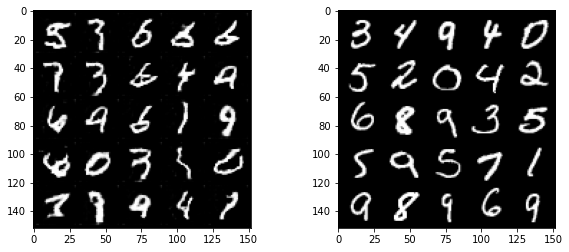

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 36 ,Step:16883 ,Generator loss: 0.6952404867865631 ,discriminator loss: 0.6954568638476224


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 37 ,Step:17352 ,Generator loss: 0.6950159550729844 ,discriminator loss: 0.6953663287132279


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 38 ,Step:17821 ,Generator loss: 0.6947434167109576 ,discriminator loss: 0.6952557595553945


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 39 ,Step:18290 ,Generator loss: 0.6952766172413116 ,discriminator loss: 0.6951048773234849


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 40 ,Step:18759 ,Generator loss: 0.6943982276580989 ,discriminator loss: 0.6946969175897931


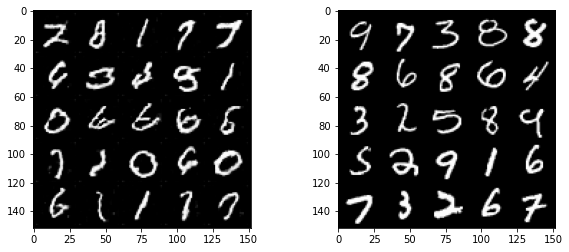

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 41 ,Step:19228 ,Generator loss: 0.6962984516930727 ,discriminator loss: 0.6948985021505788


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 42 ,Step:19697 ,Generator loss: 0.6946656360809229 ,discriminator loss: 0.6945113971797635


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 43 ,Step:20166 ,Generator loss: 0.6962747995787338 ,discriminator loss: 0.6949182633143751


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 44 ,Step:20635 ,Generator loss: 0.6942395299736623 ,discriminator loss: 0.6946367369786001


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 45 ,Step:21104 ,Generator loss: 0.6943434748822435 ,discriminator loss: 0.6946592796077607


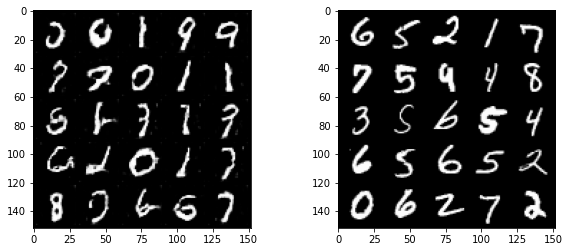

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 46 ,Step:21573 ,Generator loss: 0.6944082175999057 ,discriminator loss: 0.6944379046527558


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 47 ,Step:22042 ,Generator loss: 0.6951884254972063 ,discriminator loss: 0.6943204889673676


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 48 ,Step:22511 ,Generator loss: 0.6945621512337791 ,discriminator loss: 0.694259898748988


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 49 ,Step:22980 ,Generator loss: 0.6942052073570198 ,discriminator loss: 0.6940610987036971


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 50 ,Step:23449 ,Generator loss: 0.6949500749106092 ,discriminator loss: 0.6940932187444371


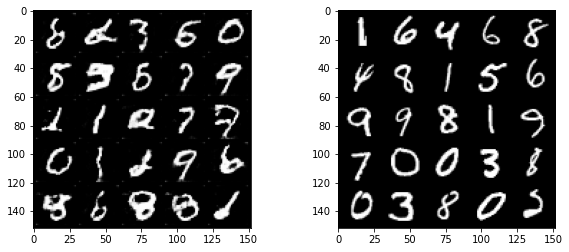

In [9]:
for epoch in range(1,n_epochs+1):
    for real, _ in tqdm(dataloader):
        real = real.to(device)
        cur_batch_size = len(real)

        ### Update discriminator ###
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_loss.backward(retain_graph=True)
        
        disc_opt.step()
        ### Update generator ###
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
        
        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / steps_per_ep
        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / steps_per_ep
        cur_step += 1
        ### Visualization code ###
       
    print(f"Epoch: {epoch} ,Step:{cur_step-1} ,Generator loss: {mean_generator_loss} ,discriminator loss: {mean_discriminator_loss}")
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    
    if epoch % display_epoch == 0 and display_epoch > 1:
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        plt.figure(1, figsize=(10,4))
        plt.subplot(1,2,1)
        show_tensor_images(fake)
        plt.subplot(1,2,2)
        show_tensor_images(real)
        plt.show()
        
        
